In [1]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from olr_class import OnlineLogisticRegression

from tqdm import tqdm_notebook

%matplotlib inline

#### prepare to test

In [2]:
# загрузка настроек
with open('./settings.json', 'r') as settings_file:
    settings = json.load(settings_file)

print('keys in settings file:')
list(settings.keys())

keys in settings file:


['data_dir',
 'data_file',
 'top_tags_count',
 'top_tags_file',
 'filtered_tmp_file',
 'train_size',
 'train_file',
 'train_labels_file',
 'test_file',
 'test_labels_file']

In [3]:
# полные пути к файлам
top_tags_filepath = os.path.join(settings['data_dir'], settings['top_tags_file'])

train_filepath = os.path.join(settings['data_dir'], settings['train_file'])
train_labels_filepath = os.path.join(settings['data_dir'], settings['train_labels_file'])

test_filepath = os.path.join(settings['data_dir'], settings['test_file'])
test_labels_filepath = os.path.join(settings['data_dir'], settings['test_labels_file'])

In [4]:
# загрузка топ тегов
top_tags_dataframe = pd.read_csv(top_tags_filepath, header=None)
top_tags = top_tags_dataframe[0].tolist()

print('top-{} tags:'.format(settings['top_tags_count']))
top_tags

top-10 tags:


['javascript',
 'java',
 'c#',
 'php',
 'android',
 'jquery',
 'python',
 'html',
 'ios',
 'c++']

In [5]:
# размер тренировочного датасета

# mac os
#train_lines_count = int(subprocess.check_output(['wc', '-l', train_filepath]).split()[0])
#test_lines_count = int(subprocess.check_output(['wc', '-l', test_filepath]).split()[0])

# windows
with open(train_filepath) as f:
    for i, l in enumerate(f):
        pass
    train_lines_count = i + 1
    
with open(test_filepath) as f:
    for i, l in enumerate(f):
        pass
    test_lines_count = i + 1
    
print('train lines count:', train_lines_count)
print('test lines count:', test_lines_count)

train lines count: 8001
test lines count: 1999


#### tqdm wrapping methods

In [6]:
# метод-обертка тренировки модели с прогресс-баром
def fit_with_tqdm(estimator, filepath, lines_count, labels_filepath, **fit_params):
    with open(filepath) as train_file, open(labels_filepath) as labels_file:
        lines_generator = (line.strip() for line in train_file)
        wrapped_lines_generator = tqdm_notebook(lines_generator, total=lines_count, mininterval=1)
        labels_generator = (line.strip().split() for line in labels_file)
        estimator.fit(datasource=wrapped_lines_generator, labels_datasource=labels_generator, **fit_params)

In [7]:
# метод-обертка предсказания с прогресс-баром
def score_with_tqdm(estimator, filepath, lines_count, labels_filepath, **score_params):
    with open(filepath) as test_file, open(labels_filepath) as labels_file:
        lines_generator = (line.strip() for line in test_file)
        wrapped_lines_generator = tqdm_notebook(lines_generator, total=lines_count, mininterval=1)
        labels_generator = (line.strip().split() for line in labels_file)
        return estimator.score(datasource=wrapped_lines_generator, labels_datasource=labels_generator, **score_params)

#### test methods

In [8]:
# проход по датасету, затем фильтрация top-25k и top-10k, после каждой - проход
# возвращает значения функции потерь и метрики качества
def test_pipeline(estimator, scheme=[], threshold=0.5):
    loss = dict()
    test_scores = dict()
    train_scores = dict()
    
    for step in scheme:
        print('{} pass'.format(step))
        
        if 'initial' in step:
            fit_with_tqdm(estimator=estimator, 
                          filepath=train_filepath, 
                          lines_count=train_lines_count,
                          labels_filepath=train_labels_filepath)
        else:
            if 'top-25k' in step:
                estimator.filter_vocab(25000)
            elif 'top-10k' in step:
                estimator.filter_vocab(10000)
            elif 'regular' in step:
                pass
                
            fit_with_tqdm(estimator=estimator, 
                          filepath=train_filepath, 
                          lines_count=train_lines_count, 
                          labels_filepath=train_labels_filepath,
                          update_vocab=False)
        
        loss[step] = estimator.loss_
        
        print('train scoring')
        score = score_with_tqdm(estimator=estimator, 
                                filepath=train_filepath, 
                                lines_count=train_lines_count, 
                                labels_filepath=train_labels_filepath,
                                threshold=threshold)
        train_scores[step] = score
        
        print('test scoring')
        score = score_with_tqdm(estimator=estimator, 
                                filepath=test_filepath, 
                                lines_count=test_lines_count, 
                                labels_filepath=test_labels_filepath,
                                threshold=threshold)
        test_scores[step] = score
    
    return (loss, train_scores, test_scores)

In [9]:
def draw_loss(loss, train_score, test_score, title, roll=10000):
    plt.figure(figsize=(12,8))
    plt.title(title)
    for key in loss.keys():
        plt.plot(pd.Series(loss[key]).rolling(roll).mean(), 
                 label='{} (J_train={} J_test={})'.format(key, round(train_score[key], 2), 
                                                          round(test_score[key], 2)))
    plt.grid()
    plt.legend()

#### model test

In [10]:
# стратегия - ovr, регуляризация и частотный словарь активированы, порог оценки - 0.5
model_ovr = OnlineLogisticRegression(top_tags, strategy='ovr')

In [11]:
ovr_loss, ovr_train_score, ovr_test_score = test_pipeline(model_ovr, 
                                                          scheme=['initial', 'top-25k', 'top-10k'])

initial pass



train scoring



test scoring



top-25k pass



train scoring



test scoring



top-10k pass



train scoring



test scoring


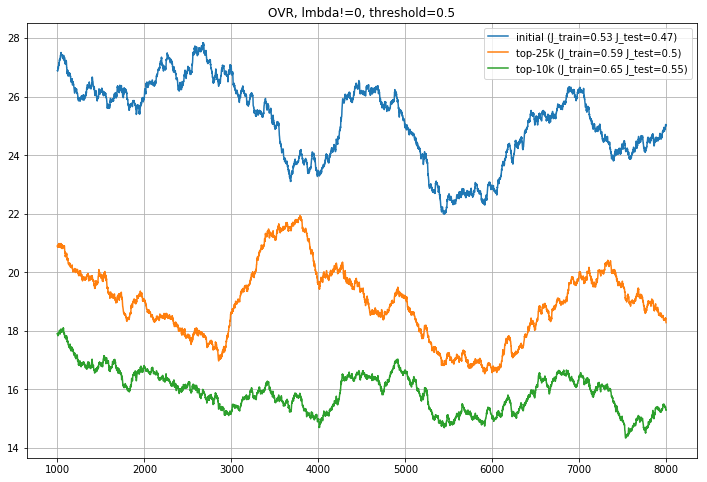

In [12]:
title = 'OVR, lmbda!=0, threshold=0.5'
draw_loss(ovr_loss, ovr_train_score, ovr_test_score, title=title, roll=1000)

---

In [13]:
# стратегия - multinomial, регуляризация и частотный словарь активированы, порог оценки - 0.2
model_mn = OnlineLogisticRegression(top_tags, strategy='multinomial')

In [14]:
mn_loss, mn_train_score, mn_test_score = test_pipeline(model_mn, 
                                                       scheme=['initial', 'top-25k', 'top-10k'], 
                                                       threshold=0.2)

initial pass



train scoring



test scoring



top-25k pass



train scoring



test scoring



top-10k pass



train scoring



test scoring


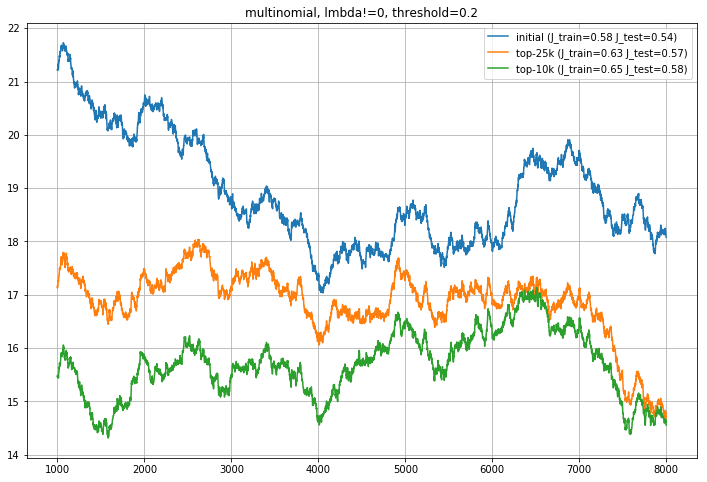

In [19]:
title = 'multinomial, lmbda!=0, threshold=0.2'
draw_loss(mn_loss, mn_train_score, mn_test_score, title=title, roll=1000)

---

In [16]:
# стратегия - ovr, регуляризация и частотный словарь деактивированы, порог оценки - 0.8
model_multipass = OnlineLogisticRegression(top_tags, strategy='ovr', lmbda=0.0, store_frequency=False)

In [17]:
mp_loss, mp_train_score, mp_test_score = test_pipeline(model_multipass, 
                                                       scheme=['initial', 'regular_1', 'regular_2', 'regular_3'],
                                                       threshold=0.8)

initial pass



train scoring



test scoring



regular_1 pass



train scoring



test scoring



regular_2 pass



train scoring



test scoring



regular_3 pass



train scoring



test scoring


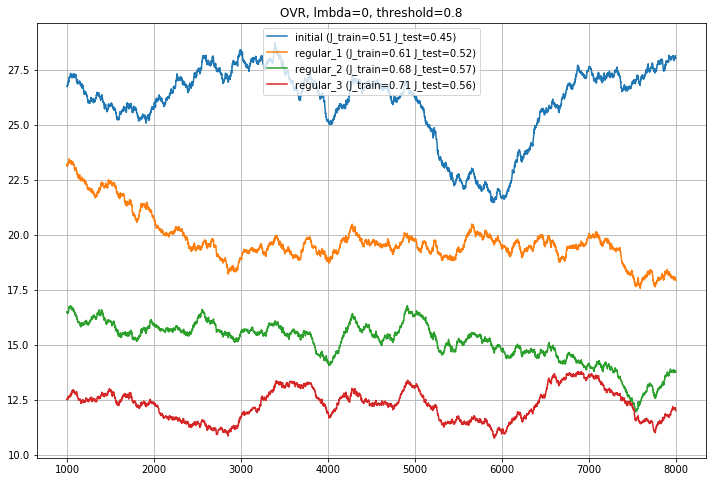

In [20]:
title = 'OVR, lmbda=0, threshold=0.8'
draw_loss(mp_loss, mp_train_score, mp_test_score, title=title, roll=1000)